In [9]:
%matplotlib inline 
%config InlineBackend.figure_format='retina'
import pandas as pd
import numpy as np
import time
import  matplotlib.pyplot as plt
import urllib.request, json 
import requests
#import plotly
#import plotly.graph_objects as go
#from plotly.subplots import make_subplots
import datetime


def get_kline(startTime,limit,symbol,interval):
    if interval[-1] == 'm':
        endTime = int(startTime+(limit*int(interval[:-1])*60*1000))
        
    data = requests.get('https://fapi.binance.com/fapi/v1/klines', params={"symbol" : symbol,
                                                        "interval" : interval, 
                                                        "startTime" : startTime,
                                                        "endTime"   : endTime,
                                                        "limit": limit}).json()
    #data  = pd.DataFrame(data)
    data  = pd.DataFrame(data,columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_vol', 'no_of_trades', 'tb_base_vol', 'tb_quote_vol', 'ignore' ])
    data.iloc[:,1:]=data.iloc[:,1:].astype(float)
    data['time'] = pd.to_datetime(data['timestamp'], unit='ms')
    return data

In [10]:
lookback_date = "31/05/2022"
date = datetime.datetime.strptime(lookback_date, "%d/%m/%Y")
timestamp_lookback = datetime.datetime.timestamp(date)

In [11]:
timestamp_now = datetime.datetime.now().timestamp()
ticker = 'ETHUSDT'
timeframe = '1m'
time_del = timestamp_now-timestamp_lookback
timestep = int(timeframe[:-1])
no_loop  = round(time_del/(timestep*60*1000))

In [12]:
%%time
#download the historical price, you can change the candle resolution
kline = get_kline(startTime=timestamp_lookback*1000,limit=1000,symbol=ticker,interval=timeframe)
for i in range(no_loop):
    kline_temp = get_kline(startTime=kline['timestamp'].values[-1],limit=1000,symbol=ticker,interval=timeframe)
    kline=pd.concat([kline,kline_temp]).drop_duplicates().reset_index(drop=True)
    
kline=pd.concat([kline,kline_temp]).drop_duplicates().reset_index(drop=True)
kline = kline.groupby('timestamp').mean().reset_index() #getting rid of the repeated values
kline['time'] = pd.to_datetime(kline['timestamp'], unit='ms')
#download the historical price, you can change the candle resolution
kline = get_kline(startTime=timestamp_lookback*1000,limit=1000,symbol=ticker,interval=timeframe)
for i in range(no_loop):
    kline_temp = get_kline(startTime=kline['timestamp'].values[-1],limit=1000,symbol=ticker,interval=timeframe)
    kline=pd.concat([kline,kline_temp]).drop_duplicates().reset_index(drop=True)
    
kline=pd.concat([kline,kline_temp]).drop_duplicates().reset_index(drop=True)
kline = kline.groupby('timestamp').mean().reset_index() #getting rid of the repeated values
kline['time'] = pd.to_datetime(kline['timestamp'], unit='ms')



#calculate the percentage change
close_pct = kline['close'].pct_change()
#removing NaN values
close_pct  = close_pct[~np.isnan(close_pct)]


#calculate the percentage change
close_pct = kline['close'].pct_change()
#removing NaN values
close_pct  = close_pct[~np.isnan(close_pct)]

CPU times: user 490 ms, sys: 97.6 ms, total: 588 ms
Wall time: 5.79 s


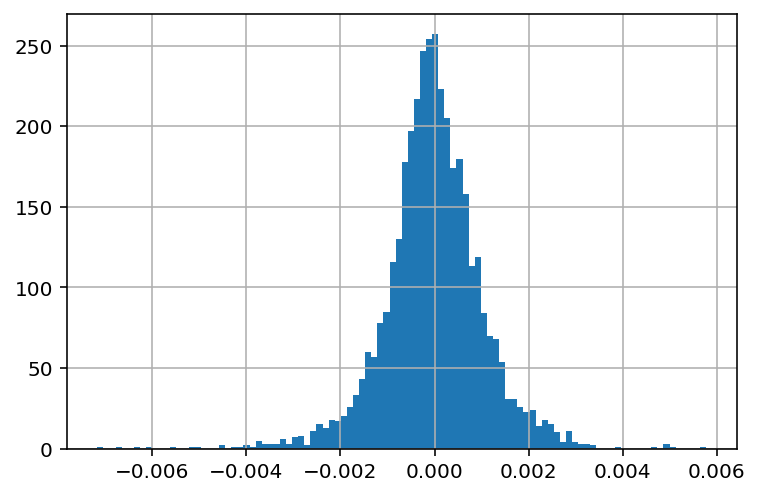

In [13]:
close_pct.hist(bins=100)

In [14]:
#####simulation settings#####
no_of_candle = 1000
sample_size = 1000
sim_size=(no_of_candle,sample_size)
########################
# Drawing the random samples based on the historical price 
#here you can improve or change the distribution as you wish
close_pct_sim = np.random.choice(close_pct,size=sim_size)
########################
close_ic= kline['close'].iloc[-1]
close_sim = close_ic*(close_pct_sim+1).cumprod(axis=0)

time_ic=kline['timestamp'].iloc[-1]
timestep= kline['timestamp'].iloc[1]-kline['timestamp'].iloc[0]
time_sim = np.arange(no_of_candle)*timestep+time_ic

In [ ]:
df=pd.DataFrame(close_sim)
df.index = pd.to_datetime(time_sim,unit='ms')
close_ic= kline['close'].iloc[-1]
price_pred_std    = np.std(close_sim,axis=1)
# plotly figure
fig=go.Figure()
for i in range(1, sample_size):
        #print(str(i))
        fig.add_trace(go.Scatter(x=df.index,
                                 y=df[df.columns[i]].values,
                                 showlegend=False,           # hides trace name from legend
                                 hoverinfo='skip',           # turns off hoverinfo
                                 name = 'random walk',
                                 mode = 'lines',
                                 line_color='black',
                                 opacity = 0.005
                                )
                     )

# add median of all rows to the plot
df_median=df.median(axis=1).to_frame()
df_median.columns=['median']
# show median
fig.add_trace(go.Scatter(x=df_median.index, y=df_median['median'].values,
                          name='Predicted Median Price',
                          line_color='red',
                          line=dict(width=2),
                          mode='lines')
             )

fig.add_trace(go.Scatter(x=df_median.index, y=df_median['median'].values-price_pred_std,
                          name='Lower 1 Sigma',
                          line_color='orange',
                          line=dict(width=2,dash = 'dot'),
                          mode='lines')
             )

fig.add_trace(go.Scatter(x=df_median.index, y=df_median['median'].values+price_pred_std,
                          name='Upper 1 Sigma',
                          line_color='orange',
                          line=dict(width=2,dash = 'dot'),
                          mode='lines')
             )


fig.show()

median:  1738.840368412501
high:  1794.5683056427013
low:  1683.1124311823007


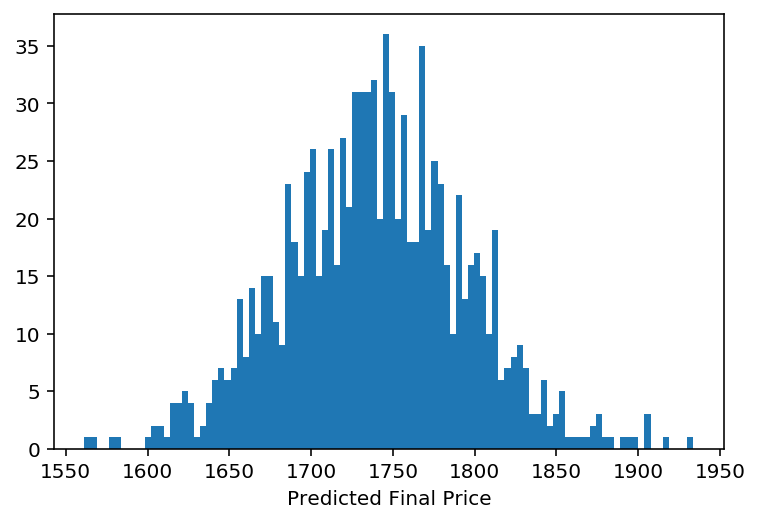

In [15]:
plt.hist(close_sim[-1,:],bins=100)
plt.xlabel('Predicted Final Price')
print('median: ',np.median(close_sim[-1,:]))
print('high: '  ,np.median(close_sim[-1,:])+np.std(close_sim[-1,:]))
print('low: '   ,np.median(close_sim[-1,:])-np.std(close_sim[-1,:]))